In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from scipy.ndimage import gaussian_filter1d
import sklearn

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

import pickle
import sys
import os
from copy import deepcopy

### Used for Colab environment to load data from GDisc.

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir("drive/MyDrive/mvi-sp")
except ImportError:
  pass

### Preferably use CUDA as primary device.

In [3]:
device = "cpu"

In [4]:
if torch.cuda.is_available():
  device = "cuda"
  torch.set_default_device(device)

### Preprocessing the time sereis and putting them into PyTorch Dataset object  for easier manipulation and feeding them into the model.

We load the input parquet and csv files and create a Dataset. We first extract individual time series and transform them with the provided transform. We also create the target vector for each time series.

In [5]:
class SleepTimeSeriesDataset(Dataset):

    def __init__(self, time_sereis_path, events_path, transform=None, use_time=False, drop_incomplete_events=False):
        time_series_df = pd.read_parquet(time_sereis_path)
        events_df = pd.read_csv(events_path)

        if use_time:
            time_series_df["daytime_seconds"] = time_series_df["timestamp"].str.slice(11,13).astype(int) * 3600 + time_series_df["timestamp"].str.slice(14,16).astype(int) * 60 + time_series_df["timestamp"].str.slice(17,19).astype(int)

        ts_ids = time_series_df["series_id"].unique()

        columns_to_select = ["anglez", "enmo"]
        if use_time:
            columns_to_select.append("daytime_seconds")

        #self.time_series = [time_series_df[time_series_df["series_id"] == id][columns_to_select].to_numpy() for id in ts_ids]

        self.time_series = []
        for id in ts_ids:
            ts = time_series_df[time_series_df["series_id"] == id][columns_to_select].to_numpy()
            if transform:
                ts = transform(ts)
            self.time_series.append(ts)


        def generate_state_vector(time_series, start_boundary, end_boundary,uncertain_side='none'):
                x = np.linspace(0,len(time_series),len(time_series))
                steepness = (end_boundary - start_boundary) / 5
                state_vector = np.zeros_like(time_series)

                if uncertain_side == 'none':
                    state_vector[start_boundary:end_boundary] = 1
                elif uncertain_side == 'left':
                    state_vector = 1 / (1 + np.exp(-steepness * (x - start_boundary)))
                    state_vector[end_boundary:] = 0
                elif uncertain_side == 'right':
                    state_vector = 1 - 1 / (1 + np.exp(-steepness * (x - end_boundary)))
                    state_vector[:start_boundary] = 0

                return state_vector

        def remove_missing_events(events_df):
            grouped = events_df.groupby("event")
            result_df = pd.DataFrame({
                'onset': grouped.get_group('onset')['step'].values,
                'wakeup': grouped.get_group('wakeup')['step'].values
            })

            condition = result_df["onset"].isna() & result_df["wakeup"].isna()
            result_df = result_df[~condition]
            result_df["duration"] = result_df["wakeup"] - result_df["onset"]
            if drop_incomplete_events:
                result_df.dropna(inplace=True)
            return result_df

        def create_target(changepoints_df, ts_length):
            changepoints_df = remove_missing_events(changepoints_df)

            # some events for given timesereis are all nan -> remove this time series
            if changepoints_df.empty:
                return None

            target = np.zeros(ts_length)
            average_duration = int(changepoints_df["duration"].mean())
            for _, row in changepoints_df.iterrows():
                onset = row["onset"]
                wakeup = row["wakeup"]
                if not pd.isna(onset) and not pd.isna(wakeup):
                    from_ = int(onset)
                    to_ = int(wakeup)
                    target = np.max((target, generate_state_vector(target, from_, to_)), axis=0)
                elif pd.isna(onset):
                    to_ = int(wakeup)
                    from_ = np.max((to_ - average_duration, 0))
                    target = np.max((target, generate_state_vector(target, from_, to_, "left")), axis=0)
                else:
                    from_ = int(onset)
                    to_ = np.min((len(target), from_ + average_duration))
                    target = np.max((target, generate_state_vector(target, from_, to_, "right")), axis=0)

            return target

        self.targets = []
        for i, id in reversed(list(enumerate(ts_ids))):
            target = create_target(events_df[events_df["series_id"] == id], len(self.time_series[i]))
            if target is None:
                # we can't get a valid target -> we remove the time series as well
                del self.time_series[i]
            else:
                self.targets.insert(0, target)


    def __len__(self):
        return len(self.time_series)

    def __getitem__(self, index):
        return self.time_series[index], self.targets[index]

First transformation that can be used is standard scaling. Doing it this way, we assume that the scale is the same for all timeseries. Otherwise, We should calculate the mean and variance from all time series only from the training dataset.

In [6]:
# use independently only when assuming, that scales of all timeseries are approximately the same
# otherwise, calculate the mean and standard deviation from all time series in training set
class Standardize:

    def __call__(self, x):
        return (x - x.mean(axis=0)) / x.std(axis=0)

Next possible transformation is the gauusian smoothing.

In [7]:
class Smooth:

    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, x):
        return gaussian_filter1d(x, sigma=self.sigma, axis=0)

We create the dataset object, but it takes a long time to compute, so we can either save the dataset after the creating or if one is already present, load it from file.

In [8]:
#dataset = SleepTimeSeriesDataset("train_series.parquet", "train_events.csv", transform=Standardize())

In [9]:
#with open("dataset_std_impute_targets.pickle", "wb") as file:
    #pickle.dump(dataset, file, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open("dataset_std_impute_targets.pickle", "rb") as file:
    dataset = pickle.load(file)

Splitting the dataset into trainning and validation subsets.

In [11]:
training_fraction = .8

In [12]:
training_set, validation_set = torch.utils.data.random_split(dataset, (training_fraction, 1 - training_fraction), torch.Generator(device=device).manual_seed(12))

/home/pilardan/miniconda3/envs/mvi-env/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [13]:
len(training_set)

216

In [14]:
len(validation_set)

53

In [28]:
params = {
    "batch_size": 8,
    "channels": 2,
    "lstm_size": 100,
    "linear1_size": 250,
    "p_dropout": 0.5,
    "chunk_size": 1000
}

This function is used for batch creation. As the time series have different lengths, we need to pad them based on the longet time series in the batch. We use the PackedSequence, so we can later use the information about the lengths and take it into account when calculating the loss.

In [16]:
def collate_padding(batch):
    ts = []
    targets = []
    for item in batch:
        ts.append(torch.tensor(item[0]))
        targets.append(torch.tensor(item[1], dtype=torch.float32))

    # sorting is done because of performance?
    lens = [len(series) for series in ts]
    sorted_indices = np.flip(np.argsort(lens))

    sorted_ts = []
    sorted_targets = []
    sorted_lens = []
    for i in sorted_indices:
        sorted_ts.append(ts[i])
        sorted_targets.append(targets[i])
        sorted_lens.append(lens[i])

    padded_ts = nn.utils.rnn.pad_sequence(sorted_ts, batch_first=True)
    padded_targets = nn.utils.rnn.pad_sequence(sorted_targets, batch_first=True)

    packed_ts = nn.utils.rnn.pack_padded_sequence(padded_ts, sorted_lens, batch_first=True, enforce_sorted=True)
    packed_targets = nn.utils.rnn.pack_padded_sequence(padded_targets, sorted_lens, batch_first=True, enforce_sorted=True)

    return packed_ts, packed_targets

In [17]:
training_loader = DataLoader(training_set, batch_size=params["batch_size"], collate_fn=collate_padding)
validation_loader = DataLoader(validation_set, batch_size=params["batch_size"], collate_fn=collate_padding)

In [31]:
class MySeq2SeqModel(nn.Module):

    def __init__(self, **params):
        super(MySeq2SeqModel, self).__init__()

        self.params = params

        self.lstm_layer = nn.LSTM(input_size=params["channels"], hidden_size=params["lstm_size"], batch_first=True)
        self.prediction_layer = nn.Sequential(
            nn.Linear(in_features=params["lstm_size"], out_features=params["linear1_size"]),
            nn.Tanh(),
            nn.Dropout(p=params["p_dropout"]),
            nn.Linear(in_features=params["linear1_size"], out_features=1),
            nn.Sigmoid()
        )

    # when training with limited resources, we use gradient accumulation and feed the series by chunks, so we also provide
    # last hidden state from previous chunk
    def forward(self, x, lstm_init_hidden=None):

      if lstm_init_hidden is None:
        lstm_hidden_sequence, lstm_last_hidden = self.lstm_layer(x)
      else:
        lstm_hidden_sequence, lstm_last_hidden = self.lstm_layer(x, lstm_init_hidden)

      return self.prediction_layer(lstm_hidden_sequence), lstm_last_hidden



In [19]:
model = MySeq2SeqModel(**params)

### Training the model using minibatches and chunking the time series.

In [63]:
class ModelResults:

    def __init__(self, state_dict, val_loss, description=None):
        self.state_dict = state_dict
        self.val_loss = val_loss
        self.description = description
        

In [62]:
model_results = {}

In [22]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

NameError: name 'model' is not defined

In [21]:
def train_one_epoch(model, loader):
    epoch_loss = 0
    for x, y in loader:
      optimizer.zero_grad()
    
      x, individual_lengths = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
      y, _ = nn.utils.rnn.pad_packed_sequence(y, batch_first=True)
      if "cuda" in device:
        individual_lengths = individual_lengths.cuda()
    
      series_lengths = x.shape[1]
    
      assert series_lengths == individual_lengths[0]

      # mask ensures, that we penalize only the relevant parts of the output
      mask = torch.arange(series_lengths)[None, :] < individual_lengths[:, None]
      batch_loss = 0
      lstm_init_hidden = None
      for chunk_slice in sklearn.utils.gen_batches(series_lengths, params["chunk_size"]):
        chunk_slice_size = chunk_slice.stop - chunk_slice.start
        
        chunk_mask = mask[:, chunk_slice]
        y_chunk_pred, lstm_init_hidden = model(x[:,chunk_slice], lstm_init_hidden)
        y_chunk_pred = y_chunk_pred.squeeze()
        y_chunk = y[:,chunk_slice]

        loss = criterion(y_chunk_pred * chunk_mask, y_chunk * chunk_mask) * (chunk_slice_size / series_lengths)
          
        loss.backward()
        batch_loss += loss.data
        lstm_init_hidden = (lstm_init_hidden[0].detach(), lstm_init_hidden[1].detach())
    
      epoch_loss += batch_loss.detach()
      optimizer.step()
        
    epoch_loss = epoch_loss / len(loader)
    return epoch_loss

In [22]:
def validate(model, loader):

    with torch.no_grad():
        total_loss = 0
        for x, y in loader:
    
          x, individual_lengths = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
          y, _ = nn.utils.rnn.pad_packed_sequence(y, batch_first=True)
          if "cuda" in device:
            individual_lengths = individual_lengths.cuda()
    
          series_lengths = x.shape[1]
    
          assert series_lengths == individual_lengths[0]
    
          mask = torch.arange(series_lengths)[None, :] < individual_lengths[:, None]
          batch_loss = 0
          lstm_init_hidden = None
          for chunk_slice in sklearn.utils.gen_batches(series_lengths, params["chunk_size"]):
            chunk_slice_size = chunk_slice.stop - chunk_slice.start
            chunk_mask = mask[:, chunk_slice]
            y_chunk_pred, lstm_init_hidden = model(x[:,chunk_slice], lstm_init_hidden)
            y_chunk_pred = y_chunk_pred.squeeze()
            y_chunk = y[:,chunk_slice]
        
            loss = criterion(y_chunk_pred * chunk_mask, y_chunk * chunk_mask) * (chunk_slice_size / series_lengths)
          
            batch_loss += loss.data
            lstm_init_hidden = (lstm_init_hidden[0].detach(), lstm_init_hidden[1].detach())
    
          total_loss += batch_loss.detach()
        
        total_loss = total_loss / len(loader)
        return total_loss

In [38]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

epochs = 20

epoch_training_losses = []
epoch_validation_losses = []

best_val_loss = np.inf

for i in range(epochs):
    print(f"Epoch {i+1} ", end="")
    model.train()
    epoch_train_loss = train_one_epoch(model, training_loader)
    epoch_training_losses.append(epoch_train_loss)
    model.eval()
    epoch_val_loss = validate(model, validation_loader)
    epoch_validation_losses.append(epoch_val_loss)
    
    print(f"Training loss: {epoch_train_loss}, validation loss: {epoch_val_loss}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        model_results["variant1"] = ModelResults(deepcopy(model.state_dict()), best_val_loss)
    

Epoch 1 Training loss: 0.5804526209831238, validation loss: 0.32070279121398926
Epoch 2 Training loss: 0.29238998889923096, validation loss: 0.23462837934494019
Epoch 3 Training loss: 0.24931970238685608, validation loss: 0.1880989521741867
Epoch 4 Training loss: 0.22298918664455414, validation loss: 0.1807733029127121
Epoch 5 Training loss: 0.2132083624601364, validation loss: 0.16978970170021057
Epoch 6 Training loss: 0.20825481414794922, validation loss: 0.1637313812971115
Epoch 7 Training loss: 0.20280778408050537, validation loss: 0.1650530993938446
Epoch 8 Training loss: 0.20084449648857117, validation loss: 0.1567508429288864
Epoch 9 Training loss: 0.19373854994773865, validation loss: 0.15093310177326202
Epoch 10 Training loss: 0.2783298194408417, validation loss: 1.2021321058273315
Epoch 11 Training loss: 0.7250285148620605, validation loss: 0.35096442699432373
Epoch 12 Training loss: 0.6975910067558289, validation loss: 0.6434667706489563
Epoch 13 Training loss: 0.52558410167

As we can see, after some number of epochs, the loss increased significantly for the training data. This might imply that the learning rate is too high and we jumped over the local optimum. We can now try it with lower learning rate.

In [47]:
model = MySeq2SeqModel(**params)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)

In [48]:
epoch_training_losses = []
epoch_validation_losses = []

best_val_loss = np.inf

for i in range(epochs):
    print(f"Epoch {i+1} ", end="")
    model.train()
    epoch_train_loss = train_one_epoch(model)
    epoch_training_losses.append(epoch_train_loss)
    model.eval()
    epoch_val_loss = validate(model)
    epoch_validation_losses.append(epoch_val_loss)
    
    print(f"Training loss: {epoch_train_loss}, validation loss: {epoch_val_loss}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        model_results["variant2"] = ModelResults(deepcopy(model.state_dict()), best_val_loss)

Epoch 1 Training loss: 0.36819469928741455, validation loss: 0.24626319110393524
Epoch 2 Training loss: 0.3018215596675873, validation loss: 0.23833364248275757
Epoch 3 Training loss: 0.27641862630844116, validation loss: 0.22103174030780792
Epoch 4 Training loss: 0.2656206786632538, validation loss: 0.24831537902355194
Epoch 5 Training loss: 0.29573240876197815, validation loss: 0.2122139036655426
Epoch 6 Training loss: 0.25245216488838196, validation loss: 0.23030635714530945
Epoch 7 Training loss: 0.3295202851295471, validation loss: 0.25012731552124023
Epoch 8 Training loss: 0.2900899052619934, validation loss: 0.27275463938713074
Epoch 9 Training loss: 0.2794778048992157, validation loss: 0.20908315479755402
Epoch 10 Training loss: 0.2600366771221161, validation loss: 0.20470160245895386
Epoch 11 Training loss: 0.24539603292942047, validation loss: 0.20056907832622528
Epoch 12 Training loss: 0.23333071172237396, validation loss: 0.1884385645389557
Epoch 13 Training loss: 0.2286362

We still get some training loss fluctuation and the first learning rate setting resulted in better validation loss.

In [49]:
torch.save(model_results["variant1"].state_dict, "variant1.model")

The size of the recurrent layer was smaller than in the original paper because of the initial memory problems. We change it back and see if we get some improvement. Originally, the paper described a lstm layzer of size 300, but due to big memory and computational overhead, we will first try the value of 200 and see fi there is an improvement.

In [26]:
params["lstm_size"] = 200

In [27]:
model = MySeq2SeqModel(**params)

In [28]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [29]:
epoch_training_losses = []
epoch_validation_losses = []

best_val_loss = np.inf

epochs=20

for i in range(epochs):
    print(f"Epoch {i+1} ", end="")
    model.train()
    epoch_train_loss = train_one_epoch(model)
    epoch_training_losses.append(epoch_train_loss)
    model.eval()
    epoch_val_loss = validate(model)
    epoch_validation_losses.append(epoch_val_loss)
    
    print(f"Training loss: {epoch_train_loss}, validation loss: {epoch_val_loss}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        model_results["variant3"] = ModelResults(deepcopy(model.state_dict()), best_val_loss)

Epoch 1 Training loss: 0.4879204332828522, validation loss: 0.24529653787612915
Epoch 2 Training loss: 0.3423745632171631, validation loss: 0.25627821683883667
Epoch 3 Training loss: 0.2969721257686615, validation loss: 0.23916852474212646
Epoch 4 Training loss: 0.2757500112056732, validation loss: 0.22970350086688995
Epoch 5 Training loss: 0.2526698708534241, validation loss: 0.20246607065200806
Epoch 6 Training loss: 0.24474717676639557, validation loss: 0.18643121421337128
Epoch 7 Training loss: 0.22384178638458252, validation loss: 0.17893709242343903
Epoch 8 Training loss: 0.22070476412773132, validation loss: 0.18677003681659698
Epoch 9 Training loss: 0.2144635021686554, validation loss: 0.17874260246753693
Epoch 10 Training loss: 0.21454903483390808, validation loss: 0.18630151450634003
Epoch 11 Training loss: 0.21785937249660492, validation loss: 0.18221242725849152
Epoch 12 Training loss: 0.21314607560634613, validation loss: 0.17730487883090973
Epoch 13 Training loss: 0.21579

We see no extra improvement in the validation loss.

Next thing we can try is to do some more preprocessing on the input time series, the smoothing for example.

We have to choose a parameter sigma representing the size of the window, that is used to calculate the mean. We can plot the resulting time series and choose the parameter experimentally.

In [65]:
ts = training_set[0][0]

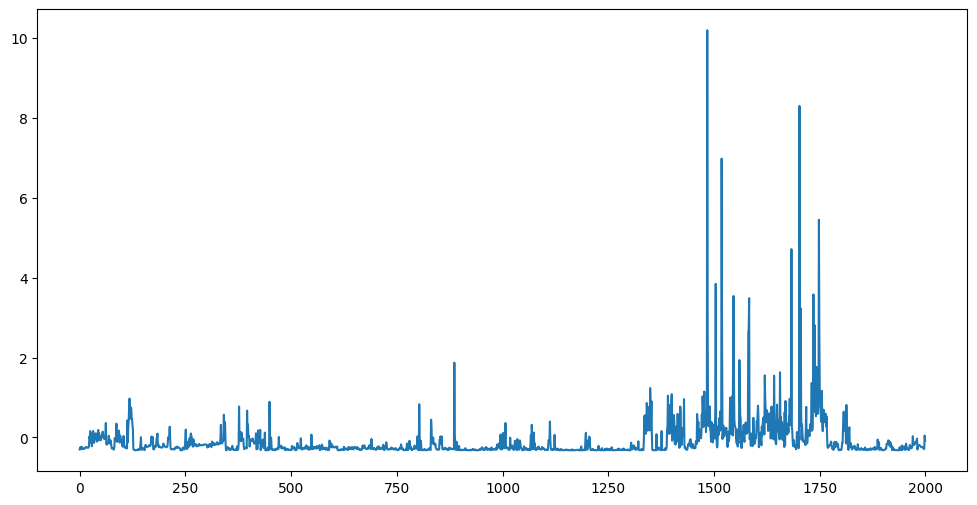

In [66]:
plt.figure(figsize=(12,6))
plt.plot(ts[:2000,1])

In [67]:
ts_smooth = Smooth(2)(ts)

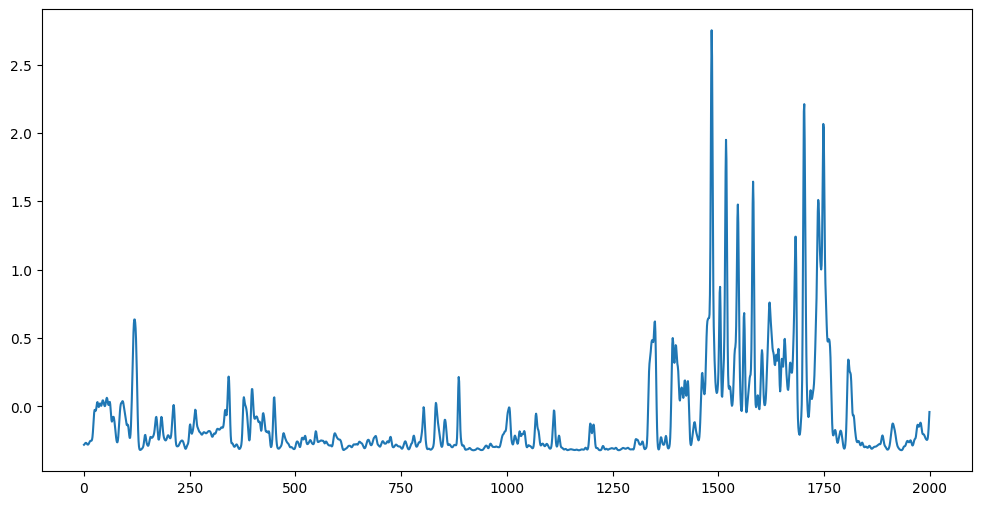

In [68]:
plt.figure(figsize=(12,6))
plt.plot(ts_smooth[:2000,1])

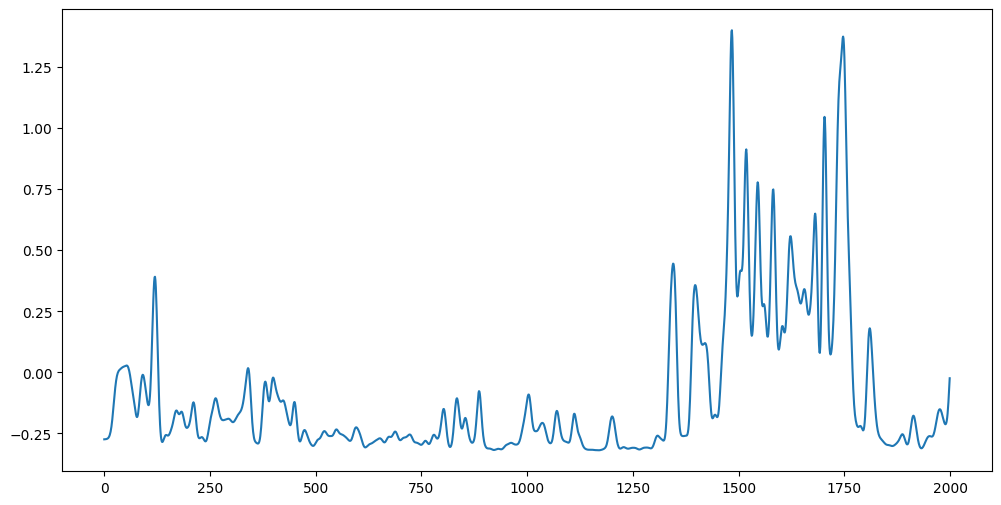

In [70]:
ts_smooth_2 = Smooth(5)(ts)
plt.figure(figsize=(12,6))
plt.plot(ts_smooth_2[:2000,1])

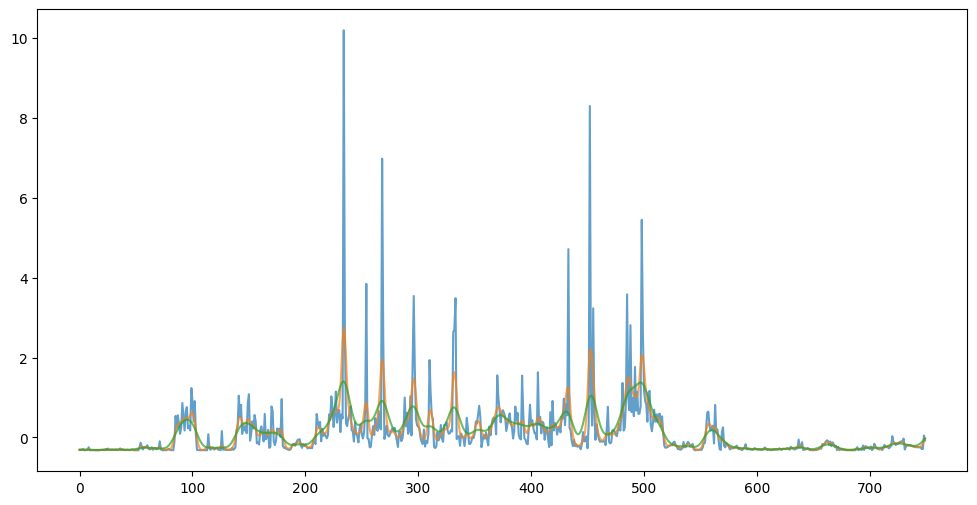

In [78]:
plt.figure(figsize=(12,6))
plt.plot(ts[1250:2000,1], alpha=.7)
plt.plot(ts_smooth[1250:2000,1],alpha=.7)
plt.plot(ts_smooth_2[1250:2000,1],alpha=.7)

For the sigma we will choose the value 5, as it still represents the course of the original time series, but supresses the sudden deviations. We have to construct the Dataset again, but we won't create it the same way as we did for the first dataset, we just use the first one, where the data is only standardized.

In [79]:
class SleepTimeSeriesDatasetSmooth(Dataset):

    def __init__(self, normalized_ts_dataset):
        self.time_series = []
        self.targets = deepcopy(normalized_ts_dataset.targets)

        smooth = Smooth(sigma=5)
        
        for ts in normalized_ts_dataset.time_series:
            self.time_series.append(smooth(ts))
            
    def __len__(self):
        return len(self.time_series)

    def __getitem__(self, index):
        return self.time_series[index], self.targets[index]

In [80]:
dataset_smooth = SleepTimeSeriesDatasetSmooth(dataset)

In [82]:
with open("dataset_smooth.pickle", "wb") as file:
    pickle.dump(dataset_smooth, file, protocol=pickle.HIGHEST_PROTOCOL)

In [85]:
training_set_smooth, validation_set_smooth = torch.utils.data.random_split(dataset_smooth, (training_fraction, 1 - training_fraction), torch.Generator(device=device).manual_seed(12))

In [86]:
training_loader_smooth = DataLoader(training_set_smooth, batch_size=params["batch_size"], collate_fn=collate_padding)
validation_loader_smooth = DataLoader(validation_set_smooth, batch_size=params["batch_size"], collate_fn=collate_padding)

In [91]:
params["lstm_size"]=100
model = MySeq2SeqModel(**params)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [92]:
epoch_training_losses = []
epoch_validation_losses = []

best_val_loss = np.inf

epochs=20

for i in range(epochs):
    print(f"Epoch {i+1} ", end="")
    model.train()
    epoch_train_loss = train_one_epoch(model, training_loader_smooth)
    epoch_training_losses.append(epoch_train_loss)
    model.eval()
    epoch_val_loss = validate(model, validation_loader_smooth)
    epoch_validation_losses.append(epoch_val_loss)
    
    print(f"Training loss: {epoch_train_loss}, validation loss: {epoch_val_loss}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        model_results["variant4"] = ModelResults(deepcopy(model.state_dict()), best_val_loss)

Epoch 1 Training loss: 0.6985422372817993, validation loss: 0.603861927986145
Epoch 2 Training loss: 0.4881676137447357, validation loss: 0.451729416847229
Epoch 3 Training loss: 0.3996686339378357, validation loss: 0.3759568929672241
Epoch 4 Training loss: 0.40952473878860474, validation loss: 0.3743196427822113
Epoch 5 Training loss: 0.40750500559806824, validation loss: 0.38118332624435425
Epoch 6 Training loss: 0.43556034564971924, validation loss: 0.37901437282562256
Epoch 7 Training loss: 0.3936789929866791, validation loss: 0.38302090764045715
Epoch 8 Training loss: 0.41843926906585693, validation loss: 0.39306411147117615
Epoch 9 Training loss: 0.3979436457157135, validation loss: 0.37453824281692505
Epoch 10 Training loss: 0.39639991521835327, validation loss: 0.5775989294052124
Epoch 11 Training loss: 0.4300697445869446, validation loss: 0.33401715755462646
Epoch 12 Training loss: 0.43845540285110474, validation loss: 0.5122236013412476
Epoch 13 Training loss: 0.3553868532180

This step had overall worse validation score.

One of the possible limitation to achieve better results could be the length of the time sereis. We can try to resample them and use the model on the shrunk timeseries.

In [15]:
from tslearn.preprocessing import TimeSeriesResampler

/home/pilardan/miniconda3/envs/mvi-env/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


We have to select the target length. We also need to resample the target sequences, so we have to be careful not to remove any sleep states by shrinking. We can try to select the max time series length from the training set divided by 100 as the target length for example.

In [16]:
max_train_length = np.max([sample[0].shape[0] for sample in training_set])

In [17]:
target_resampling_length = max_train_length // 100

Function used to resample the time series.

In [18]:
def resample(ts, target_length):
    return TimeSeriesResampler(target_length).fit_transform(np.expand_dims(ts, axis=0)).squeeze()

In [19]:
ts, target = training_set[4]

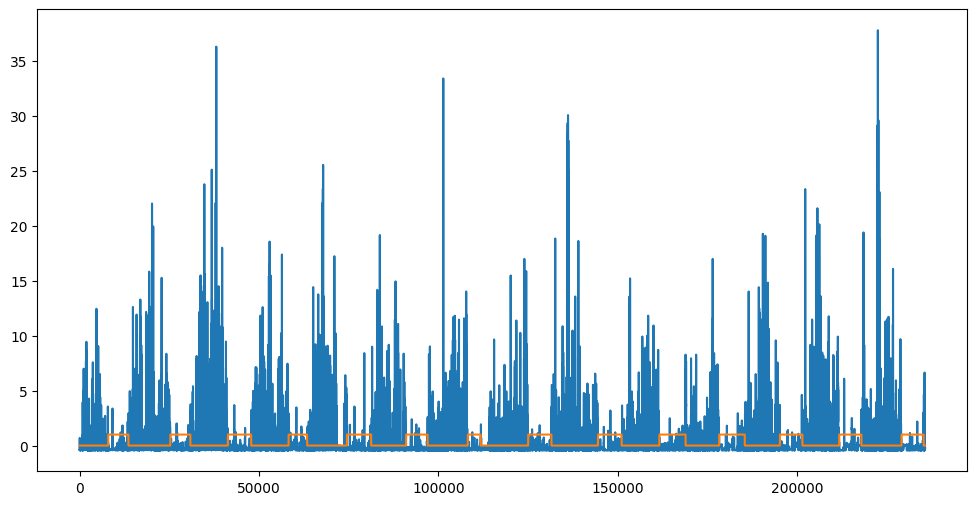

In [20]:
plt.figure(figsize=(12,6))
plt.plot(ts[:,1])
plt.plot(target)

In [21]:
ts_resampled = resample(ts, target_resampling_length)
target_resampled = resample(target, target_resampling_length)

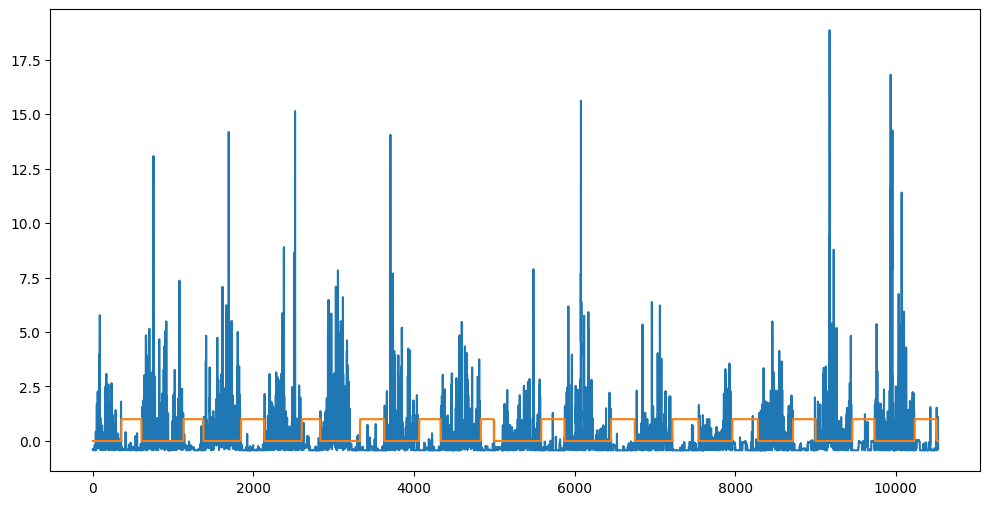

In [22]:
plt.figure(figsize=(12,6))
plt.plot(ts_resampled[:,1])
plt.plot(target_resampled)

The resampled time series as well as the target still look very similar to the original time series, but with much smaller size.

We create a new dataset with the resampling transformation, but we need to store the original lengths to transform the target back, so we can compare the validation loss with the previous models.

Again, we reuse the created dataset to construct a dataset with resampled time series.

In [23]:
class SleepTimeSeriesDatasetResampled(Dataset):

    def __init__(self, normalized_ts_dataset, target_length):
        self.time_series = []
        self.original_targets = deepcopy(normalized_ts_dataset.targets)
        self.targets = []
        
        
        for ts, target in zip(normalized_ts_dataset.time_series,normalized_ts_dataset.targets):
            self.time_series.append(Standardize()(resample(ts, target_length)))
            self.targets.append(resample(target, target_length))
            
                
    def __len__(self):
        return len(self.time_series)

    def __getitem__(self, index):
        return self.time_series[index], self.targets[index], self.original_targets[index]


In [24]:
dataset_resampled = SleepTimeSeriesDatasetResampled(dataset, target_resampling_length)

In [25]:
#with open("dataset_resampled.pickle", "wb") as file:
    #pickle.dump(dataset_resampled, file, protocol=pickle.HIGHEST_PROTOCOL)

For generating batches, we need a different collate function. A positive thing is that we don't need to pad the sequnces because they all have the same length.

In [26]:
def collate_padding_resampled(batch):
    ts = []
    targets = []
    original_targets = []
    for ts_, target, original_target in batch:
        ts.append(torch.tensor(ts_, dtype=torch.float32))
        targets.append(torch.tensor(target, dtype=torch.float32))
        original_targets.append(torch.tensor(original_target))

    return torch.stack(ts, dim=0), torch.stack(targets, dim=0), original_targets

In [29]:
training_set_resampled, validation_set_resampled = torch.utils.data.random_split(dataset_resampled, (training_fraction, 1 - training_fraction), torch.Generator(device=device).manual_seed(12))
training_loader_resampled = DataLoader(training_set_resampled, batch_size=params["batch_size"], collate_fn=collate_padding_resampled)
validation_loader_resampled = DataLoader(validation_set_resampled, batch_size=params["batch_size"], collate_fn=collate_padding_resampled)

We have to also change the training and validation functions. We also don't have to use the chunking, as the time series are much smaller. It is also easier for resampling.

In [58]:
def train_one_epoch_resampled(model, loader):
    epoch_loss = 0
    i = 0
    for x, y ,_ in loader:
      optimizer.zero_grad()

      series_length = x.shape[1]

      assert series_length == target_resampling_length
        
      y_pred, _ = model(x, None)
      y_pred = y_pred.squeeze()

      try:
          loss = criterion(y_pred, y)
      except:
          print(y_pred)
          print(i)
      loss.backward()
      epoch_loss += loss.data
      optimizer.step()
      i+=1
        
    epoch_loss = epoch_loss / len(loader)
    return epoch_loss

In [59]:
def validate_resampled(model, loader):

    with torch.no_grad():
        total_loss = 0
        for x, y, y_original in loader:
    
          # x ... stack of time series of same length
          # y_original ... list of orignal targets (have the information about original lengths)

          individual_lengths = list(map(lambda original_target: len(original_target), y_original))
 
          longest_ts = np.max(individual_lengths)
          
                    
          y_pred, _ = model(x, None)


          y_pred_resampled = []
          for i, pred_ts in enumerate(y_pred):
              y_pred_resampled.append(torch.tensor(resample(pred_ts.cpu(), individual_lengths[i]), dtype=torch.float32))
          
                      
          y_pred_resampled = torch.nn.utils.rnn.pad_sequence(y_pred_resampled, batch_first=True)
          y = torch.nn.utils.rnn.pad_sequence(y_original, batch_first=True).type(torch.float32)

          assert y_pred_resampled.shape == y.shape

            
          loss = criterion(y_pred_resampled, y)
    
          total_loss += loss.data
        
        total_loss = total_loss / len(loader)
        return total_loss

In [60]:
params["batch_size"] = 16
params["lstm_size"] = 40
model = MySeq2SeqModel(**params)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [64]:
epoch_training_losses = []
epoch_validation_losses = []

best_val_loss = np.inf

epochs=100

for i in range(epochs):
    print(f"Epoch {i+1} ", end="")
    model.train()
    epoch_train_loss = train_one_epoch_resampled(model, training_loader_resampled)
    epoch_training_losses.append(epoch_train_loss)
    model.eval()
    epoch_val_loss = validate_resampled(model, validation_loader_resampled)
    epoch_validation_losses.append(epoch_val_loss)
    
    print(f"Training loss: {epoch_train_loss}, validation loss: {epoch_val_loss}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        model_results["variant5"] = ModelResults(deepcopy(model.state_dict()), best_val_loss)

Epoch 1 Training loss: 0.4210827052593231, validation loss: 0.22365422546863556
Epoch 2 Training loss: 0.34942516684532166, validation loss: 0.20777703821659088
Epoch 3 Training loss: 0.3394187092781067, validation loss: 0.20383019745349884
Epoch 4 Training loss: 0.3339863121509552, validation loss: 0.20034267008304596
Epoch 5 Training loss: 0.3308897316455841, validation loss: 0.19748249650001526
Epoch 6 Training loss: 0.32802489399909973, validation loss: 0.19476322829723358
Epoch 7 Training loss: 0.3254125118255615, validation loss: 0.19228635728359222
Epoch 8 Training loss: 0.322820246219635, validation loss: 0.1900223344564438
Epoch 9 Training loss: 0.3201252222061157, validation loss: 0.1879444271326065
Epoch 10 Training loss: 0.3175313174724579, validation loss: 0.18609470129013062
Epoch 11 Training loss: 0.3152916133403778, validation loss: 0.18463090062141418
Epoch 12 Training loss: 0.31314006447792053, validation loss: 0.18316207826137543
Epoch 13 Training loss: 0.31088164448

This learning rate looks promising, let's keep training for more epochs.

In [65]:
epochs=1000

for i in range(100,epochs):
    print(f"Epoch {i+1} ", end="")
    model.train()
    epoch_train_loss = train_one_epoch_resampled(model, training_loader_resampled)
    epoch_training_losses.append(epoch_train_loss)
    model.eval()
    epoch_val_loss = validate_resampled(model, validation_loader_resampled)
    epoch_validation_losses.append(epoch_val_loss)
    
    print(f"Training loss: {epoch_train_loss}, validation loss: {epoch_val_loss}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        model_results["variant5"] = ModelResults(deepcopy(model.state_dict()), best_val_loss)

Epoch 101 Training loss: 0.23956726491451263, validation loss: 0.13779065012931824
Epoch 102 Training loss: 0.2329300493001938, validation loss: 0.1318357139825821
Epoch 103 Training loss: 0.23023581504821777, validation loss: 0.13474225997924805
Epoch 104 Training loss: 0.23028123378753662, validation loss: 0.13026946783065796
Epoch 105 Training loss: 0.22990769147872925, validation loss: 0.1299646496772766
Epoch 106 Training loss: 0.2286093831062317, validation loss: 0.13273005187511444
Epoch 107 Training loss: 0.22842752933502197, validation loss: 0.13265830278396606
Epoch 108 Training loss: 0.2305779606103897, validation loss: 0.1294044703245163
Epoch 109 Training loss: 0.22853995859622955, validation loss: 0.13382819294929504
Epoch 110 Training loss: 0.23391081392765045, validation loss: 0.1330663561820984
Epoch 111 Training loss: 0.2346467673778534, validation loss: 0.13334417343139648
Epoch 112 Training loss: 0.23170152306556702, validation loss: 0.1346779465675354
Epoch 113 Tra

It seems that with resampling, we helped the model.

In [66]:
torch.save(model_results["variant5"].state_dict, "variant5.model")

In [67]:
model_results["variant5"].val_loss

tensor(0.0877, device='cuda:0')

## Postprocessing

We can't use the model output directly to analyze accuracy becasue the output signal is still very noisy and we want dichotomic values.

As it is stated in the data description, recorded sleep cycle must be at least 30 minutes long. We can use this information to filter out the output even more. First, we need to calculate number of step in out timeseries that is 30 minutes long.  We know that the data were measured every 5 seconds.

Our preprocessing steps consist of: smoothing the output, using minmax normalization, using moving median filtration, and thresholding on value 0.5. Finally, we apply the rule of 30 minutes to filter out sleep states that shouldn't be recorded. The sizes of windows and other postprocessing parameters were experimentally selected on one of the training time series.

In [34]:
min_sleep_length = (30 * 60) / 5

In [33]:
best_model = MySeq2SeqModel(**params)
best_model.load_state_dict(torch.load("variant5.model"))

<All keys matched successfully>

In [35]:
def moving_median(arr, window_size):
    padded_arr = np.pad(arr, (window_size // 2, window_size // 2), mode='edge')

    rolling_windows = np.lib.stride_tricks.sliding_window_view(padded_arr, (window_size,))

    medians = np.median(rolling_windows, axis=1)

    return medians

In [36]:
def minmax_normalize(data):
    
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    
    normalized_data = (data - min_val) / (max_val - min_val)
    
    return normalized_data

In [37]:
def apply_30_min_rule(result, min_cycle_length):
    # first find sleep cycles
    cycles = []
    start = None
    for i, value in enumerate(result):
        if value == 1:
            if start is None:
                start = i
        else:
            if start is not None:
                cycles.append((start, i - 1))
                start = None

    if start is not None:
        cycles.append((start, len(result) - 1))

    valid_cycles = []

    def is_valid(cycle):
        return cycle[1] - cycle[0] + 1 >= min_cycle_length
    
    for i in range(len(cycles)):

        extended_cycle = [cycles[i][0], cycles[i][1]]
        
        if is_valid(cycles[i]):
            for j in range(i - 1, -1, -1):
                if extended_cycle[0] - cycles[j][1] < min_cycle_length:
                    extended_cycle[0] = cycles[j][0]                    
                else:
                    break
            for j in range(i + 1, len(cycles)):
                if cycles[j][0] - extended_cycle[1] < min_cycle_length:
                    extended_cycle[1] = cycles[j][1]
                    i = j + 1
                else:
                    break
            valid_cycles.append(extended_cycle)
    
    return valid_cycles

In [38]:
def create_array_from_cycles(cycles, length):
    output = np.zeros(length)
    for cycle in cycles:
        output[cycle[0]:cycle[1]+1] = 1
    return output

In [39]:
def postprocess_result(result):
    filtered = moving_median(minmax_normalize(Smooth(5)(result)), 3000)
    sleep_cycles = apply_30_min_rule(filtered >= 0.5, min_sleep_length)
    return create_array_from_cycles(sleep_cycles, len(result))

Let's look at the output and resulting postprocessed output.

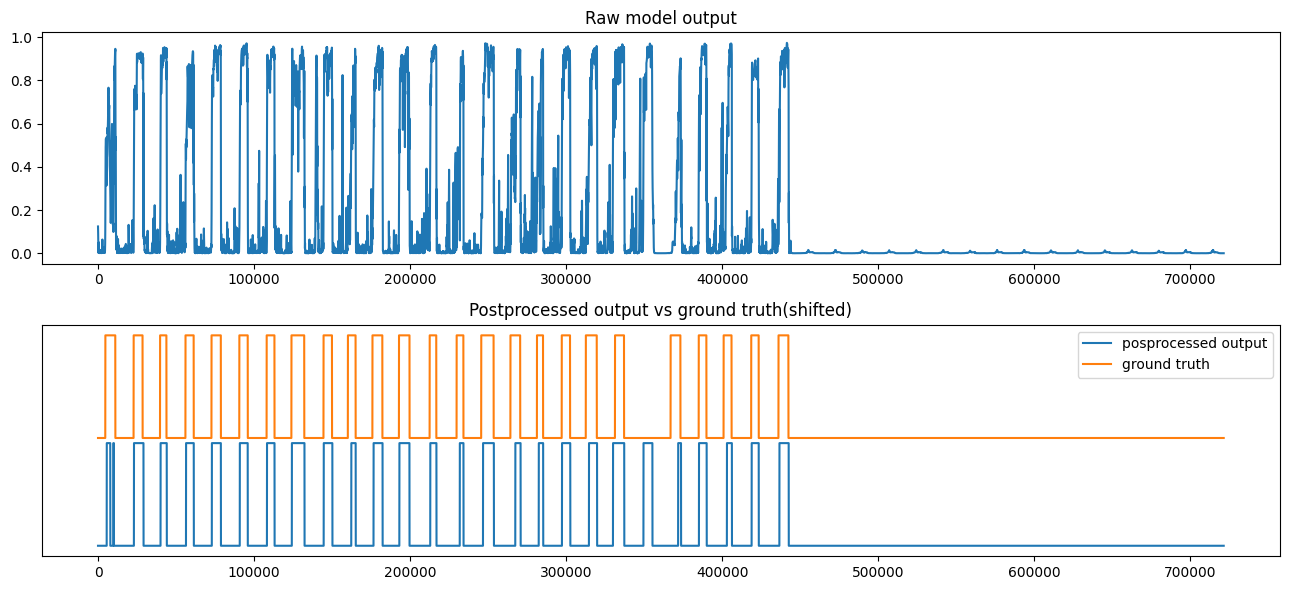

In [55]:
best_model.eval()
with torch.no_grad():
    
    for x, y, y_original in validation_loader_resampled:
        
        individual_lengths = list(map(lambda original_target: len(original_target), y_original))
 
                    
        y_pred, _ = best_model(x, None)

        outputs = []
        for i, pred_ts in enumerate(y_pred):
            resampled = resample(pred_ts.cpu(), individual_lengths[i])
            outputs.append(resampled)

        index = 4

        plt.figure(figsize=(13, 6))

        plt.subplot(2, 1, 1)
        plt.plot(outputs[index])
        plt.title("Raw model output")
        
        plt.subplot(2, 1, 2)
        plt.plot(postprocess_result(outputs[index]), label="posprocessed output")
        plt.plot(y_original[index].cpu() + 1.05, label="ground truth")
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.title("Postprocessed output vs ground truth(shifted)")
        plt.legend()
        plt.tight_layout()
        
        plt.show()
                
        break


Do a final evaluation on validation data.

In [51]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    f_score = 0
    f_score_factor = 0
    processed = 0
    
    for x, y, y_original in validation_loader_resampled:
        
        individual_lengths = list(map(lambda original_target: len(original_target), y_original))
 
                    
        y_pred, _ = best_model(x, None)


        for i, pred_ts in enumerate(y_pred):
            resampled = resample(pred_ts.cpu(), individual_lengths[i])
            postprocessed = postprocess_result(resampled)
            true = np.array(y_original[i].cpu())

            f_score += f1_score(true, postprocessed)
            f_score_factor += 1
            
            correct += (postprocessed == true).sum()
            total += len(postprocessed)

        processed +=1
        

        print(f"Processed {(processed/len(validation_loader_resampled)) *100}% of batches.")

    print()
    print(f"Accuracy: {correct / total}")
    print(f"F1-score: {f_score / f_score_factor}")

Processed 14.285714285714285% of batches.
Processed 28.57142857142857% of batches.
Processed 42.857142857142854% of batches.
Processed 57.14285714285714% of batches.
Processed 71.42857142857143% of batches.
Processed 85.71428571428571% of batches.
Processed 100.0% of batches.

Accuracy: 0.9497611033596564
F1-score: 0.8580403692502828
